Human Bone Fractures

Tải và kiểm tra dữ liệu

In [19]:
import os
import pandas as pd
from collections import Counter

# Xác nhận thư mục làm việc
print("Current working directory:", os.getcwd())

# Định nghĩa đường dẫn tương đối
base_dir = "data"
train_image_dir = os.path.join(base_dir, "train", "images")
train_label_dir = os.path.join(base_dir, "train", "labels")
val_image_dir = os.path.join(base_dir, "valid", "images")
val_label_dir = os.path.join(base_dir, "valid", "labels")
test_image_dir = os.path.join(base_dir, "test", "images")
test_label_dir = os.path.join(base_dir, "test", "labels")

# Danh sách lớp
class_names = ['Comminuted', 'Greenstick', 'Healthy', 'Linear', 'Oblique Displaced', 
               'Oblique', 'Segmental', 'Spiral', 'Transverse Displaced', 'Transverse']

# Kiểm tra số lượng file và khớp ảnh-nhãn
def check_dataset(image_dir, label_dir, dataset_name):
    if not os.path.exists(image_dir) or not os.path.exists(label_dir):
        print(f"Cannot access {image_dir} or {label_dir}")
        return 0, 0, Counter()
    
    images = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))]
    labels = [f for f in os.listdir(label_dir) if f.endswith('.txt')]
    healthy_count = 0
    fracture_count = 0
    class_counts = Counter()
    
    for img in images:
        label = img.replace('.jpg', '.txt').replace('.png', '.txt')
        if label not in labels:
            print(f"Missing label for {img} in {dataset_name}")
            healthy_count += 1  # Giả định ảnh không có nhãn là Healthy
            class_counts[2] += 1  # Healthy (class_id=2)
        else:
            label_path = os.path.join(label_dir, label)
            try:
                with open(label_path, 'r') as f:
                    lines = f.readlines()
                    if not lines or all(not line.strip() for line in lines):
                        healthy_count += 1
                        class_counts[2] += 1  # Healthy (class_id=2)
                    else:
                        fracture_count += 1
                        for line in lines:
                            if line.strip():
                                parts = line.strip().split()
                                if len(parts) >= 1:  # Ít nhất có class_id
                                    class_id = int(float(parts[0]))
                                    if class_id not in range(10):
                                        print(f"Invalid class_id {class_id} in {label} in {dataset_name}")
                                    else:
                                        class_counts[class_id] += 1
            except Exception as e:
                print(f"Error reading {label_path} in {dataset_name}: {e}")
    
    print(f"{dataset_name} - Images: {len(images)}, Labels: {len(labels)}, Healthy: {healthy_count}, Fractured: {fracture_count}")
    print(f"{dataset_name} - Class distribution:", {class_names[k]: v for k, v in class_counts.items()})
    return len(images), len(labels), class_counts

# Kiểm tra định dạng nhãn
def check_label_format(label_dir, dataset_name):
    if not os.path.exists(label_dir):
        print(f"Cannot access {label_dir}")
        return
    
    for label_file in os.listdir(label_dir):
        if label_file.endswith('.txt'):
            label_path = os.path.join(label_dir, label_file)
            try:
                with open(label_path, 'r') as f:
                    lines = f.readlines()
                    for line in lines:
                        if line.strip():
                            parts = line.strip().split()
                            if len(parts) != 5:
                                print(f"Invalid format in {label_file} in {dataset_name}: {line} (expected 5 columns)")
                            else:
                                class_id, x, y, w, h = map(float, parts)
                                if not (0 <= x <= 1 and 0 <= y <= 1 and 0 <= w <= 1 and 0 <= h <= 1):
                                    print(f"Invalid coordinates in {label_file} in {dataset_name}: {line} (x,y,w,h must be in [0,1])")
                                if int(class_id) not in range(10):
                                    print(f"Invalid class_id {int(class_id)} in {label_file} in {dataset_name}")
            except Exception as e:
                print(f"Error reading {label_path} in {dataset_name}: {e}")

# Thực hiện kiểm tra
print("\nTrain dataset:")
train_images, train_labels, train_class_counts = check_dataset(train_image_dir, train_label_dir, "Train")
print("\nValidation dataset:")
val_images, val_labels, val_class_counts = check_dataset(val_image_dir, val_label_dir, "Validation")
print("\nTest dataset:")
test_images, test_labels, test_class_counts = check_dataset(test_image_dir, test_label_dir, "Test")

print("\nChecking label format:")
check_label_format(train_label_dir, "Train")
check_label_format(val_label_dir, "Validation")
check_label_format(test_label_dir, "Test")

Current working directory: c:\Users\vanqu\OneDrive\Máy tính\nhan_dang_mau

Train dataset:
Train - Images: 1347, Labels: 1347, Healthy: 3, Fractured: 1344
Train - Class distribution: {'Transverse Displaced': 630, 'Spiral': 66, 'Oblique Displaced': 342, 'Healthy': 57, 'Segmental': 18, 'Comminuted': 168, 'Oblique': 48, 'Transverse': 120, 'Greenstick': 81, 'Linear': 21}

Validation dataset:
Validation - Images: 128, Labels: 128, Healthy: 0, Fractured: 128
Validation - Class distribution: {'Transverse Displaced': 65, 'Oblique Displaced': 30, 'Healthy': 7, 'Spiral': 5, 'Segmental': 3, 'Comminuted': 15, 'Oblique': 7, 'Transverse': 14, 'Greenstick': 10, 'Linear': 1}

Test dataset:
Test - Images: 64, Labels: 64, Healthy: 0, Fractured: 64
Test - Class distribution: {'Spiral': 3, 'Oblique Displaced': 17, 'Transverse Displaced': 23, 'Oblique': 2, 'Transverse': 8, 'Comminuted': 9, 'Healthy': 3, 'Greenstick': 1}

Checking label format:


Tiền xử lý dữ liệu

In [20]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import random

# 1. Tiền xử lý dữ liệu: Đếm phân bố lớp
def count_classes(label_dir):
    class_counts = Counter()
    if not os.path.exists(label_dir):
        print(f"Cannot access {label_dir}")
        return class_counts
    for label_file in os.listdir(label_dir):
        if label_file.endswith('.txt'):
            label_path = os.path.join(label_dir, label_file)
            try:
                with open(label_path, 'r') as f:
                    lines = f.readlines()
                    if not lines or all(not line.strip() for line in lines):
                        class_counts[2] += 1  # File rỗng là "Healthy" (class_id=2)
                    else:
                        for line in lines:
                            if line.strip():
                                class_id = int(float(line.strip().split()[0]))
                                if class_id not in range(10):
                                    print(f"Invalid class_id {class_id} in {label_file}")
                                else:
                                    class_counts[class_id] += 1
            except Exception as e:
                print(f"Error reading {label_path}: {e}")
    return class_counts

# Đếm lớp cho từng tập
train_class_counts = count_classes(train_label_dir)
val_class_counts = count_classes(val_label_dir)
test_class_counts = count_classes(test_label_dir)

# In phân bố lớp
print("\nClass distribution:")
print(f"Train: {dict(train_class_counts)}")
print(f"Validation: {dict(val_class_counts)}")
print(f"Test: {dict(test_class_counts)}")

# Kiểm tra số lượng ảnh và nhãn
def check_dataset(image_dir, label_dir, dataset_name):
    if not os.path.exists(image_dir) or not os.path.exists(label_dir):
        print(f"Cannot access {image_dir} or {label_dir}")
        return 0, 0
    images = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))]
    labels = [f for f in os.listdir(label_dir) if f.endswith('.txt')]
    print(f"\n{dataset_name} - Images: {len(images)}, Labels: {len(labels)}")
    for img in images:
        label = img.replace('.jpg', '.txt').replace('.png', '.txt')
        if label not in labels:
            print(f"Missing label for {img} in {dataset_name}")
    return len(images), len(labels)

# Thực hiện kiểm tra
train_images, train_labels = check_dataset(train_image_dir, train_label_dir, "Train")
val_images, val_labels = check_dataset(val_image_dir, val_label_dir, "Validation")
test_images, test_labels = check_dataset(test_image_dir, test_label_dir, "Test")



Class distribution:
Train: {8: 630, 7: 66, 4: 342, 2: 57, 6: 18, 0: 168, 5: 48, 9: 120, 1: 81, 3: 21}
Validation: {8: 65, 4: 30, 2: 7, 7: 5, 6: 3, 0: 15, 5: 7, 9: 14, 1: 10, 3: 1}
Test: {7: 3, 4: 17, 8: 23, 5: 2, 9: 8, 0: 9, 2: 3, 1: 1}

Train - Images: 1347, Labels: 1347

Validation - Images: 128, Labels: 128

Test - Images: 64, Labels: 64


Trực quan hóa dữ liệu

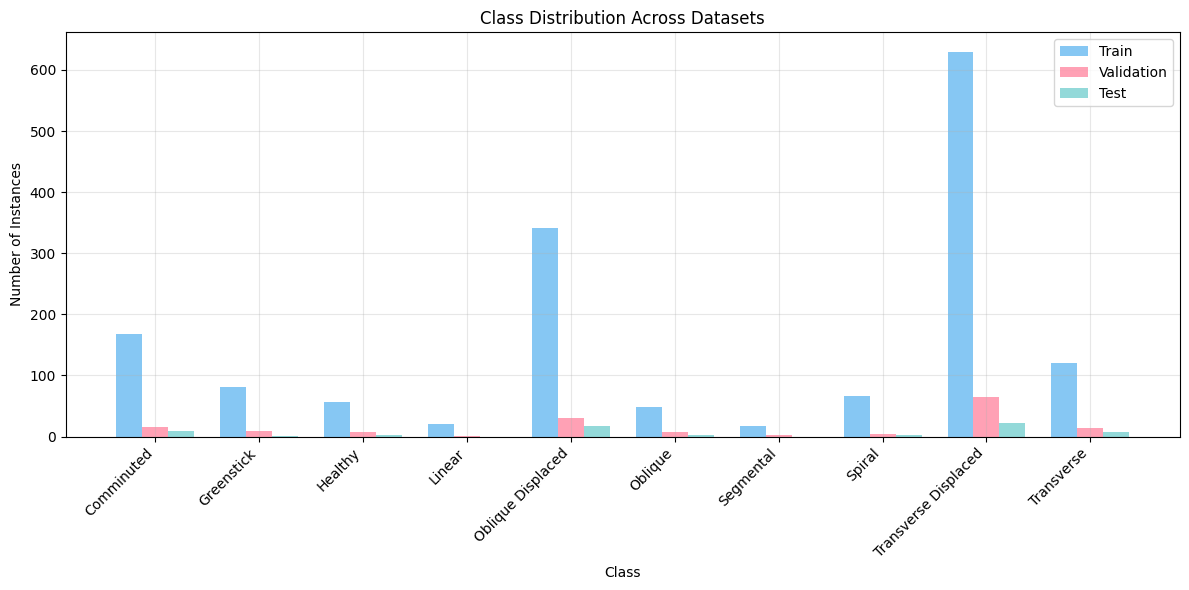

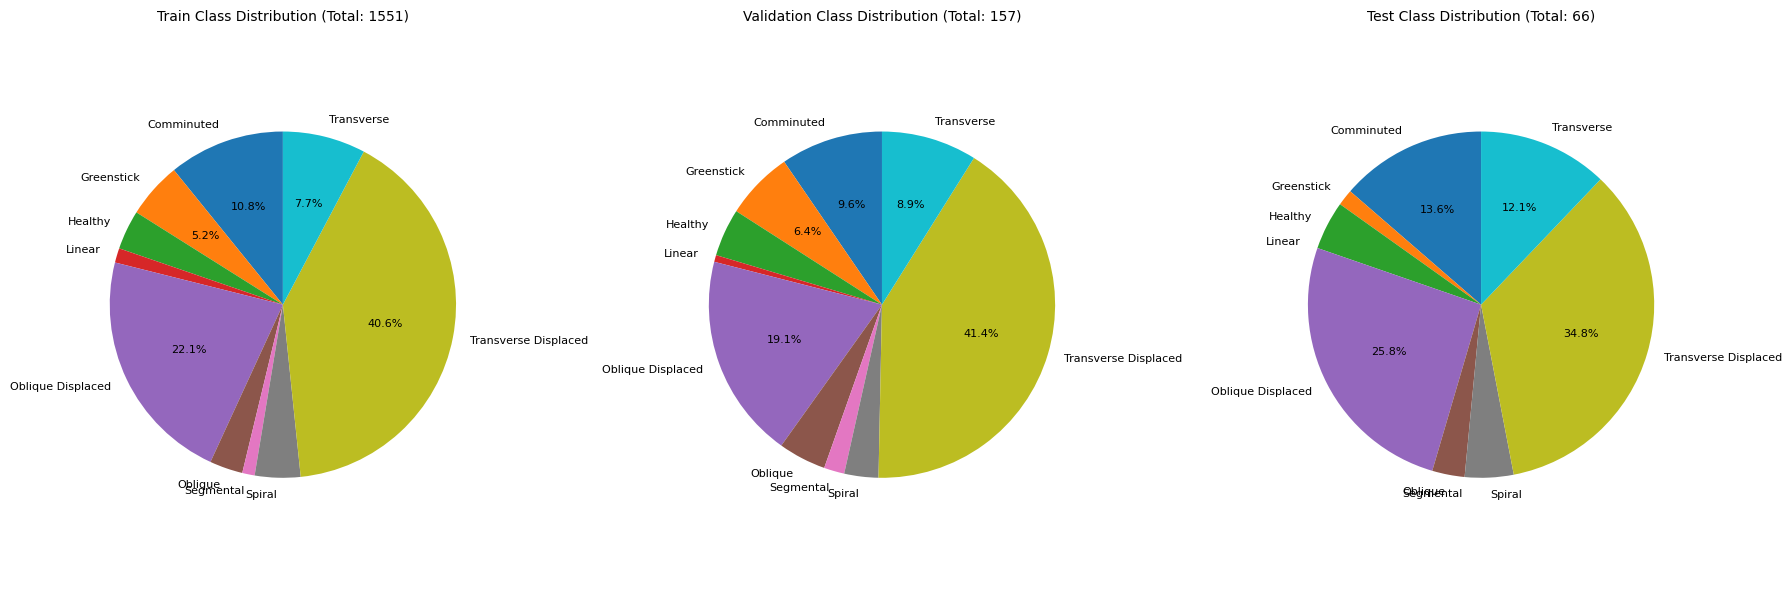

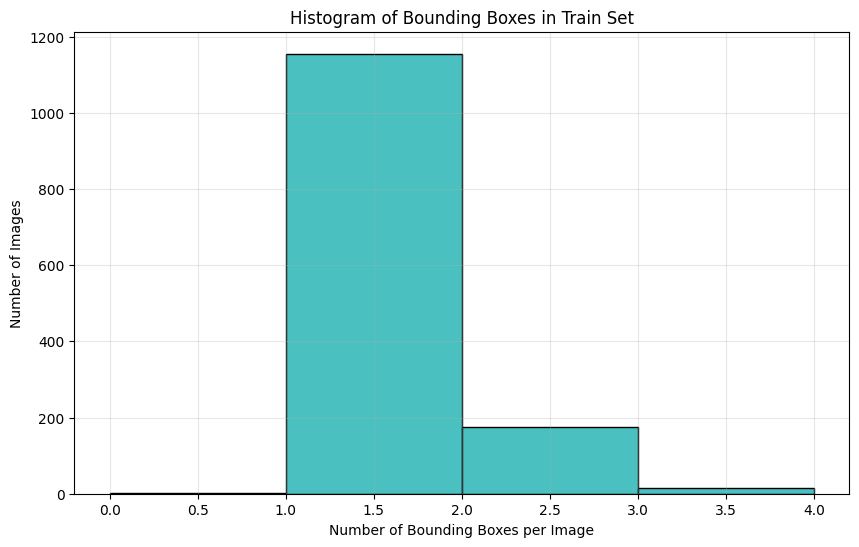

Average number of boxes per image in Train: 1.15


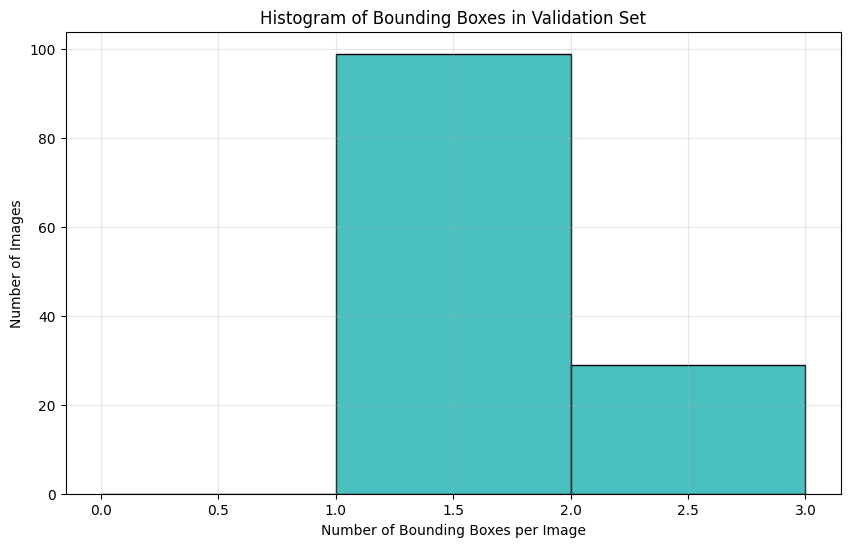

Average number of boxes per image in Validation: 1.23


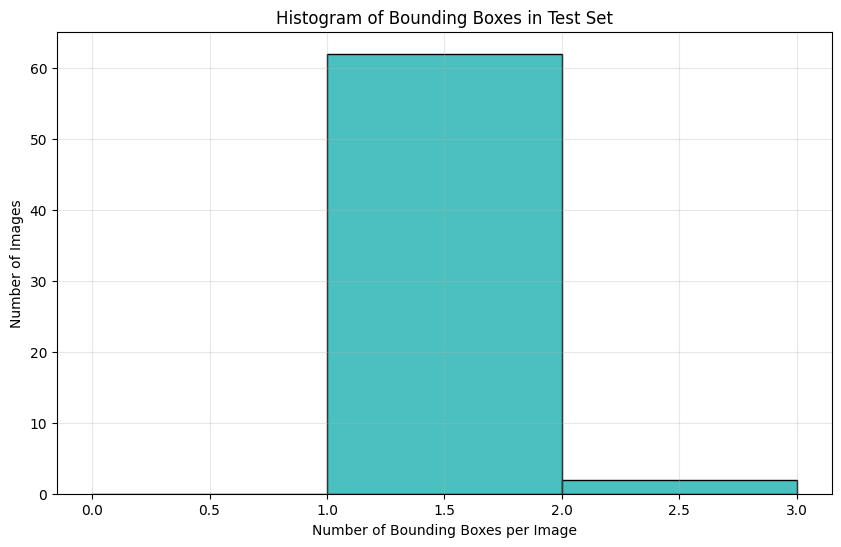

Average number of boxes per image in Test: 1.03
Displaying sample images from Train set:


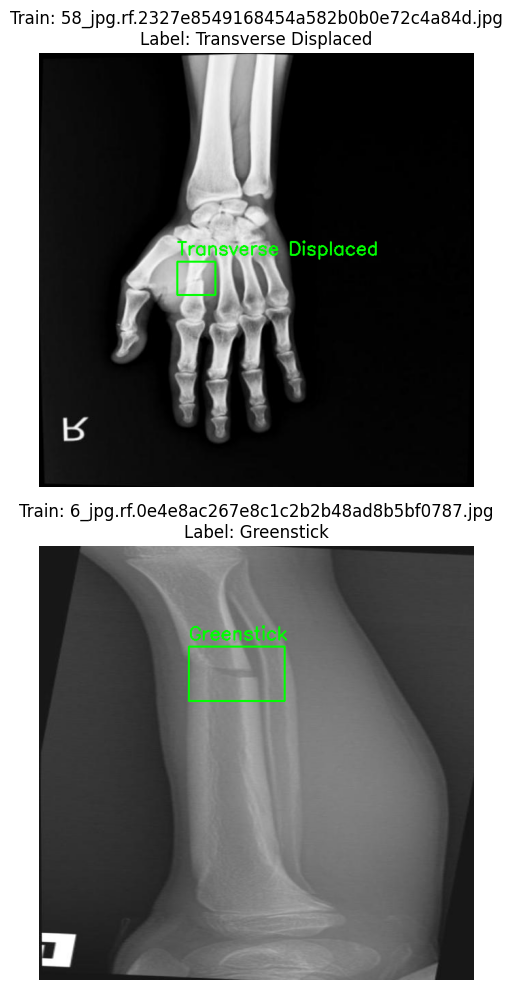


Displaying sample images from Validation set:


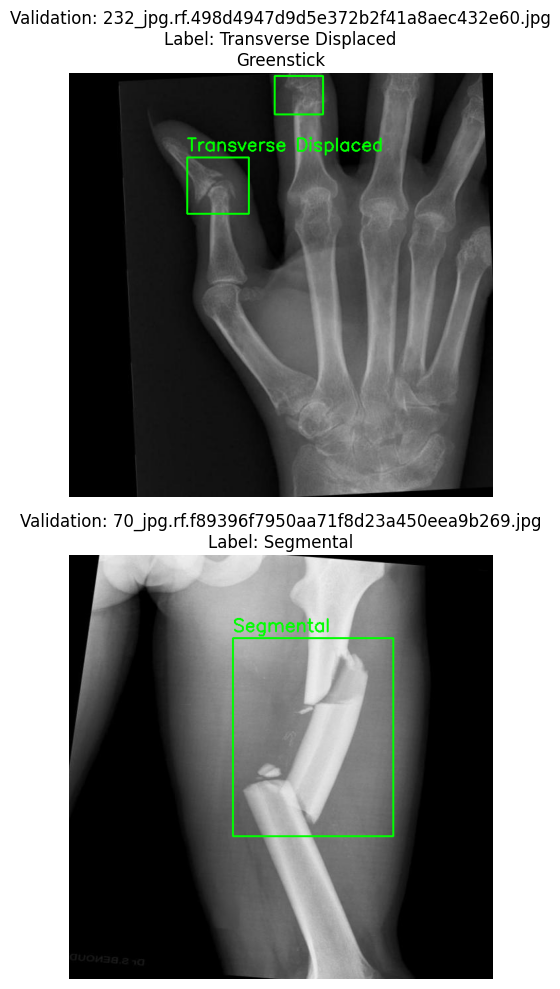


Displaying sample images from Test set:


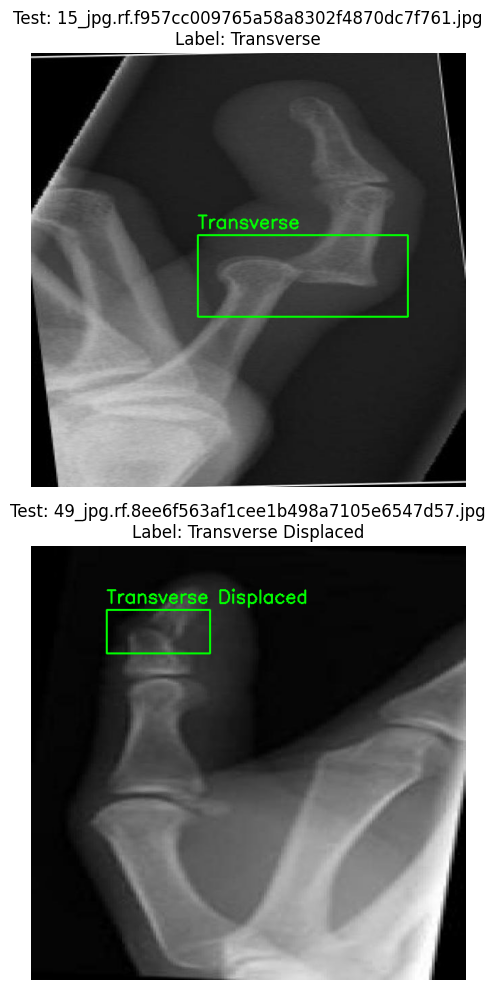

In [21]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import random

# Hàm đếm phân bố lớp
def count_classes(label_dir):
    class_counts = Counter()
    if not os.path.exists(label_dir):
        print(f"Cannot access {label_dir}")
        return class_counts
    for label_file in os.listdir(label_dir):
        if label_file.endswith('.txt'):
            label_path = os.path.join(label_dir, label_file)
            try:
                with open(label_path, 'r') as f:
                    lines = f.readlines()
                    if not lines or all(not line.strip() for line in lines):
                        class_counts[2] += 1  # File rỗng là "Healthy" (class_id=2)
                    else:
                        for line in lines:
                            if line.strip():
                                class_id = int(float(line.strip().split()[0]))
                                if class_id not in range(10):
                                    print(f"Invalid class_id {class_id} in {label_file}")
                                else:
                                    class_counts[class_id] += 1
            except Exception as e:
                print(f"Error reading {label_path}: {e}")
    return class_counts

# Đếm phân bố lớp
train_class_counts = count_classes(train_label_dir)
val_class_counts = count_classes(val_label_dir)
test_class_counts = count_classes(test_label_dir)

# 2.1. Biểu đồ cột: Phân bố lớp trên các tập dữ liệu
plt.figure(figsize=(12, 6))
x = np.arange(len(class_names))
width = 0.25
train_counts = [train_class_counts.get(i, 0) for i in range(10)]
val_counts = [val_class_counts.get(i, 0) for i in range(10)]
test_counts = [test_class_counts.get(i, 0) for i in range(10)]
if any(counts == 0 for counts in [train_counts, val_counts, test_counts]):
    print("Warning: One or more datasets have no class counts.")
plt.bar(x - width, train_counts, width, label='Train', color=(54/255, 162/255, 235/255, 0.6))
plt.bar(x, val_counts, width, label='Validation', color=(255/255, 99/255, 132/255, 0.6))
plt.bar(x + width, test_counts, width, label='Test', color=(75/255, 192/255, 192/255, 0.6))
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.title('Class Distribution Across Datasets')
plt.xticks(x, class_names, rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3)  # Thêm lưới
plt.tight_layout()
plt.show()

# 2.2. Biểu đồ tròn: Phân bố lớp cho từng tập
def plot_pie(ax, counts, title, total):
    if not counts or sum(counts) == 0:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center')
        ax.set_title(title)
        return
    ax.pie(counts, labels=class_names if total > 5 else [name[:3] for name in class_names], 
           autopct=lambda p: f'{p:.1f}%' if p > 5 else '', startangle=90, textprops={'fontsize': 8})
    ax.axis('equal')
    ax.set_title(f'{title} (Total: {total})', fontsize=10)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
plot_pie(ax1, train_counts, 'Train Class Distribution', sum(train_counts))
plot_pie(ax2, val_counts, 'Validation Class Distribution', sum(val_counts))
plot_pie(ax3, test_counts, 'Test Class Distribution', sum(test_counts))
plt.tight_layout()
plt.show()

# 2.3. Histogram số lượng hộp bao
def get_box_counts(label_dir):
    box_counts = []
    if not os.path.exists(label_dir):
        print(f"Cannot access {label_dir}")
        return box_counts
    for label_file in os.listdir(label_dir):
        if label_file.endswith('.txt'):
            label_path = os.path.join(label_dir, label_file)
            try:
                with open(label_path, 'r') as f:
                    lines = f.readlines()
                    box_counts.append(len(lines))
            except Exception as e:
                print(f"Error reading {label_path}: {e}")
    return box_counts

box_counts_train = get_box_counts(train_label_dir)
box_counts_val = get_box_counts(val_label_dir)
box_counts_test = get_box_counts(test_label_dir)

for dataset_name, counts in [('Train', box_counts_train), ('Validation', box_counts_val), ('Test', box_counts_test)]:
    if counts:
        plt.figure(figsize=(10, 6))
        plt.hist(counts, bins=range(max(counts)+2) if counts else [0, 1], edgecolor='black', color=(75/255, 192/255, 192/255))
        plt.xlabel('Number of Bounding Boxes per Image')
        plt.ylabel('Number of Images')
        plt.title(f'Histogram of Bounding Boxes in {dataset_name} Set')
        plt.grid(True, alpha=0.3)
        plt.show()
        print(f"Average number of boxes per image in {dataset_name}: {sum(counts) / len(counts):.2f}")
    else:
        print(f"No box counts available for {dataset_name}")

# 2.4. Hiển thị ảnh mẫu với nhãn
def visualize_images_with_labels(image_dir, label_dir, dataset_name, num_samples=2):
    if not os.path.exists(image_dir) or not os.path.exists(label_dir):
        print(f"Cannot access {image_dir} or {label_dir}")
        return
    images = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))]
    if not images:
        print(f"No images found in {image_dir}")
        return
    samples = random.sample(images, min(num_samples, len(images)))
    
    plt.figure(figsize=(15, 5 * num_samples))
    for i, img_name in enumerate(samples):
        img_path = os.path.join(image_dir, img_name)
        label_path = os.path.join(label_dir, img_name.replace('.jpg', '.txt').replace('.png', '.txt'))
        
        img = cv2.imread(img_path)
        if img is None:
            print(f"Cannot load image: {img_path}")
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]
        
        label_content = "No label (Healthy)"
        if os.path.exists(label_path):
            try:
                with open(label_path, 'r') as f:
                    lines = f.readlines()
                    if lines and any(line.strip() for line in lines):
                        label_content = []
                        for line in lines:
                            if line.strip():
                                class_id, x_center, y_center, width, height = map(float, line.strip().split())
                                x1 = max(0, int((x_center - width/2) * w))  # Giới hạn tọa độ
                                y1 = max(0, int((y_center - height/2) * h))
                                x2 = min(w, int((x_center + width/2) * w))
                                y2 = min(h, int((y_center + height/2) * h))
                                if x1 < x2 and y1 < y2:  # Đảm bảo hộp hợp lệ
                                    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                                    cv2.putText(img, f'{class_names[int(class_id)]}', (x1, y1-10), 
                                               cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
                                    label_content.append(f"{class_names[int(class_id)]}")
                        label_content = '\n'.join(label_content) if label_content else "Empty label (Healthy)"
            except Exception as e:
                print(f"Error reading {label_path}: {e}")
        
        plt.subplot(num_samples, 1, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{dataset_name}: {img_name}\nLabel: {label_content}")
    plt.tight_layout()
    plt.show()

print("Displaying sample images from Train set:")
visualize_images_with_labels(train_image_dir, train_label_dir, "Train")
print("\nDisplaying sample images from Validation set:")
visualize_images_with_labels(val_image_dir, val_label_dir, "Validation")
print("\nDisplaying sample images from Test set:")
visualize_images_with_labels(test_image_dir, test_label_dir, "Test")

In [4]:
import os
import yaml

# Đường dẫn đến file data.yaml
yaml_path = os.path.join("data", "data.yaml")

# Kiểm tra và hiển thị nội dung file
if os.path.exists(yaml_path):
    with open(yaml_path, 'r', encoding='utf-8') as file:  # Thêm encoding
        yaml_content = yaml.safe_load(file)
        print("Nội dung file data.yaml:")
        print(yaml.dump(yaml_content, sort_keys=False))
else:
    print(f"File {yaml_path} không tồn tại. Vui lòng tạo file với nội dung đã đề xuất.")


Nội dung file data.yaml:
path: ./data
train: train/images
val: valid/images
test: test/images
nc: 10
names:
- Comminuted
- Greenstick
- Healthy
- Linear
- Oblique Displaced
- Oblique
- Segmental
- Spiral
- Transverse Displaced
- Transverse



Cài đặt và huấn luyện YOLOv8

In [5]:
pip install ultralytics

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: ultralytics in c:\users\vanqu\appdata\local\programs\python\python312\lib\site-packages (8.3.198)




[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
from ultralytics import YOLO
import torch
import os

# Hiển thị thư mục làm việc hiện tại
print("Working directory:", os.getcwd())

# Kiểm tra file data.yaml
yaml_path = os.path.join("data", "data.yaml")
if not os.path.exists(yaml_path):
    print(f"File {yaml_path} not found.")
else:
    print(f"Found data.yaml at: {yaml_path}")

# Tải mô hình
model = YOLO('yolov8n.pt')

# Huấn luyện (YOLOv8 tự lưu best.pt khi có cải thiện)
results = model.train(
    data="data/data.yaml",
    epochs=70,
    imgsz=640,
    batch=4,
    device=0 if torch.cuda.is_available() else 'cpu',
    patience=10,
    name='bone_fracture_yolov8_optimized',
    project='result',  # Thay đổi để lưu trong thư mục result
    augment=True,
    mosaic=1.0,
    flipud=0.5,    # Quay lại giá trị cũ
    fliplr=0.5,    # Quay lại giá trị cũ
    translate=0.1, # Quay lại giá trị cũ
    scale=0.5,     # Giữ nguyên
    plots=True
)

# Lưu mô hình cuối cùng trong thư mục result
model.save(os.path.join('result', 'bone_fracture_yolov8_optimized_final.pt'))

Working directory: c:\Users\vanqu\OneDrive\Máy tính\nhan_dang_mau
Found data.yaml at: data\data.yaml
New https://pypi.org/project/ultralytics/8.3.199 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.198  Python-3.12.1 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1650, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=70, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n

c:\Users\vanqu\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access  (ping: 0.61.0 ms, read: 29.415.3 MB/s, size: 25.9 KB)
val: Scanning C:\Users\vanqu\OneDrive\Máy tính\nhan_dang_mau\data\valid\labels.cache... 128 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 128/128 61.4Kit/s 0.0s
Plotting labels to C:\Users\vanqu\OneDrive\My tnh\nhan_dang_mau\result\bone_fracture_yolov8_optimized\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to C:\Users\vanqu\OneDrive\My tnh\nhan_dang_mau\result\bone_fracture_

Đánh giá mô hình

In [9]:
from ultralytics import YOLO
import os

# Hiển thị thư mục làm việc hiện tại
print("Working directory:", os.getcwd())

# Đường dẫn tương đối đến mô hình đã huấn luyện
model_path = os.path.join('result', 'bone_fracture_yolov8_optimized', 'weights', 'best.pt')

# Kiểm tra file mô hình
if not os.path.exists(model_path):
    print(f"Error: Model file {model_path} not found. Please check the path.")
else:
    print(f"Found model at: {model_path}")

# Tải mô hình
model = YOLO(model_path)

# Đánh giá mô hình trên tập validation
metrics = model.val(data="data/data.yaml")

# In kết quả tổng quan
print(f"mAP@50: {metrics.box.map50:.3f}")
print(f"mAP@50-95: {metrics.box.map:.3f}")
print(f"Precision: {metrics.box.p.mean():.3f}")
print(f"Recall: {metrics.box.r.mean():.3f}")


Working directory: c:\Users\vanqu\OneDrive\Máy tính\nhan_dang_mau
Found model at: result\bone_fracture_yolov8_optimized\weights\best.pt
Ultralytics 8.3.198  Python-3.12.1 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1650, 4096MiB)
Model summary (fused): 72 layers, 3,007,598 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 277.7101.5 MB/s, size: 26.5 KB)
val: Scanning C:\Users\vanqu\OneDrive\Máy tính\nhan_dang_mau\data\valid\labels.cache... 128 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 128/128 128.2Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 1.3it/s 6.1s0.3s
                   all        128        157      0.911      0.794      0.909      0.509
            Comminuted         15         15          1      0.756      0.873      0.538
            Greenstick         10         10       0.99        0.4      0.574      0.191
               Healthy          7          7 

Dự đoán trên ảnh mới

Found model at: result\bone_fracture_yolov8_optimized\weights\best.pt
Found validation directory at: data\valid\images
Found 128 images in validation directory.

Predicting on: data\valid\images\81_jpg.rf.8d29696270c13c0529993336e8b48c33.jpg

image 1/1 c:\Users\vanqu\OneDrive\My tnh\nhan_dang_mau\data\valid\images\81_jpg.rf.8d29696270c13c0529993336e8b48c33.jpg: 640x640 2 Transverse Displaceds, 75.6ms
Speed: 5.3ms preprocess, 75.6ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to C:\Users\vanqu\runs\detect\predict12
1 label saved to C:\Users\vanqu\runs\detect\predict12\labels

Predicting on: data\valid\images\118_jpg.rf.c2a4a5c8f030540defa7ab53d160074f.jpg

image 1/1 c:\Users\vanqu\OneDrive\My tnh\nhan_dang_mau\data\valid\images\118_jpg.rf.c2a4a5c8f030540defa7ab53d160074f.jpg: 640x640 1 Oblique, 61.5ms
Speed: 5.5ms preprocess, 61.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to C:\Users\vanqu\runs\detect\predict12
2 

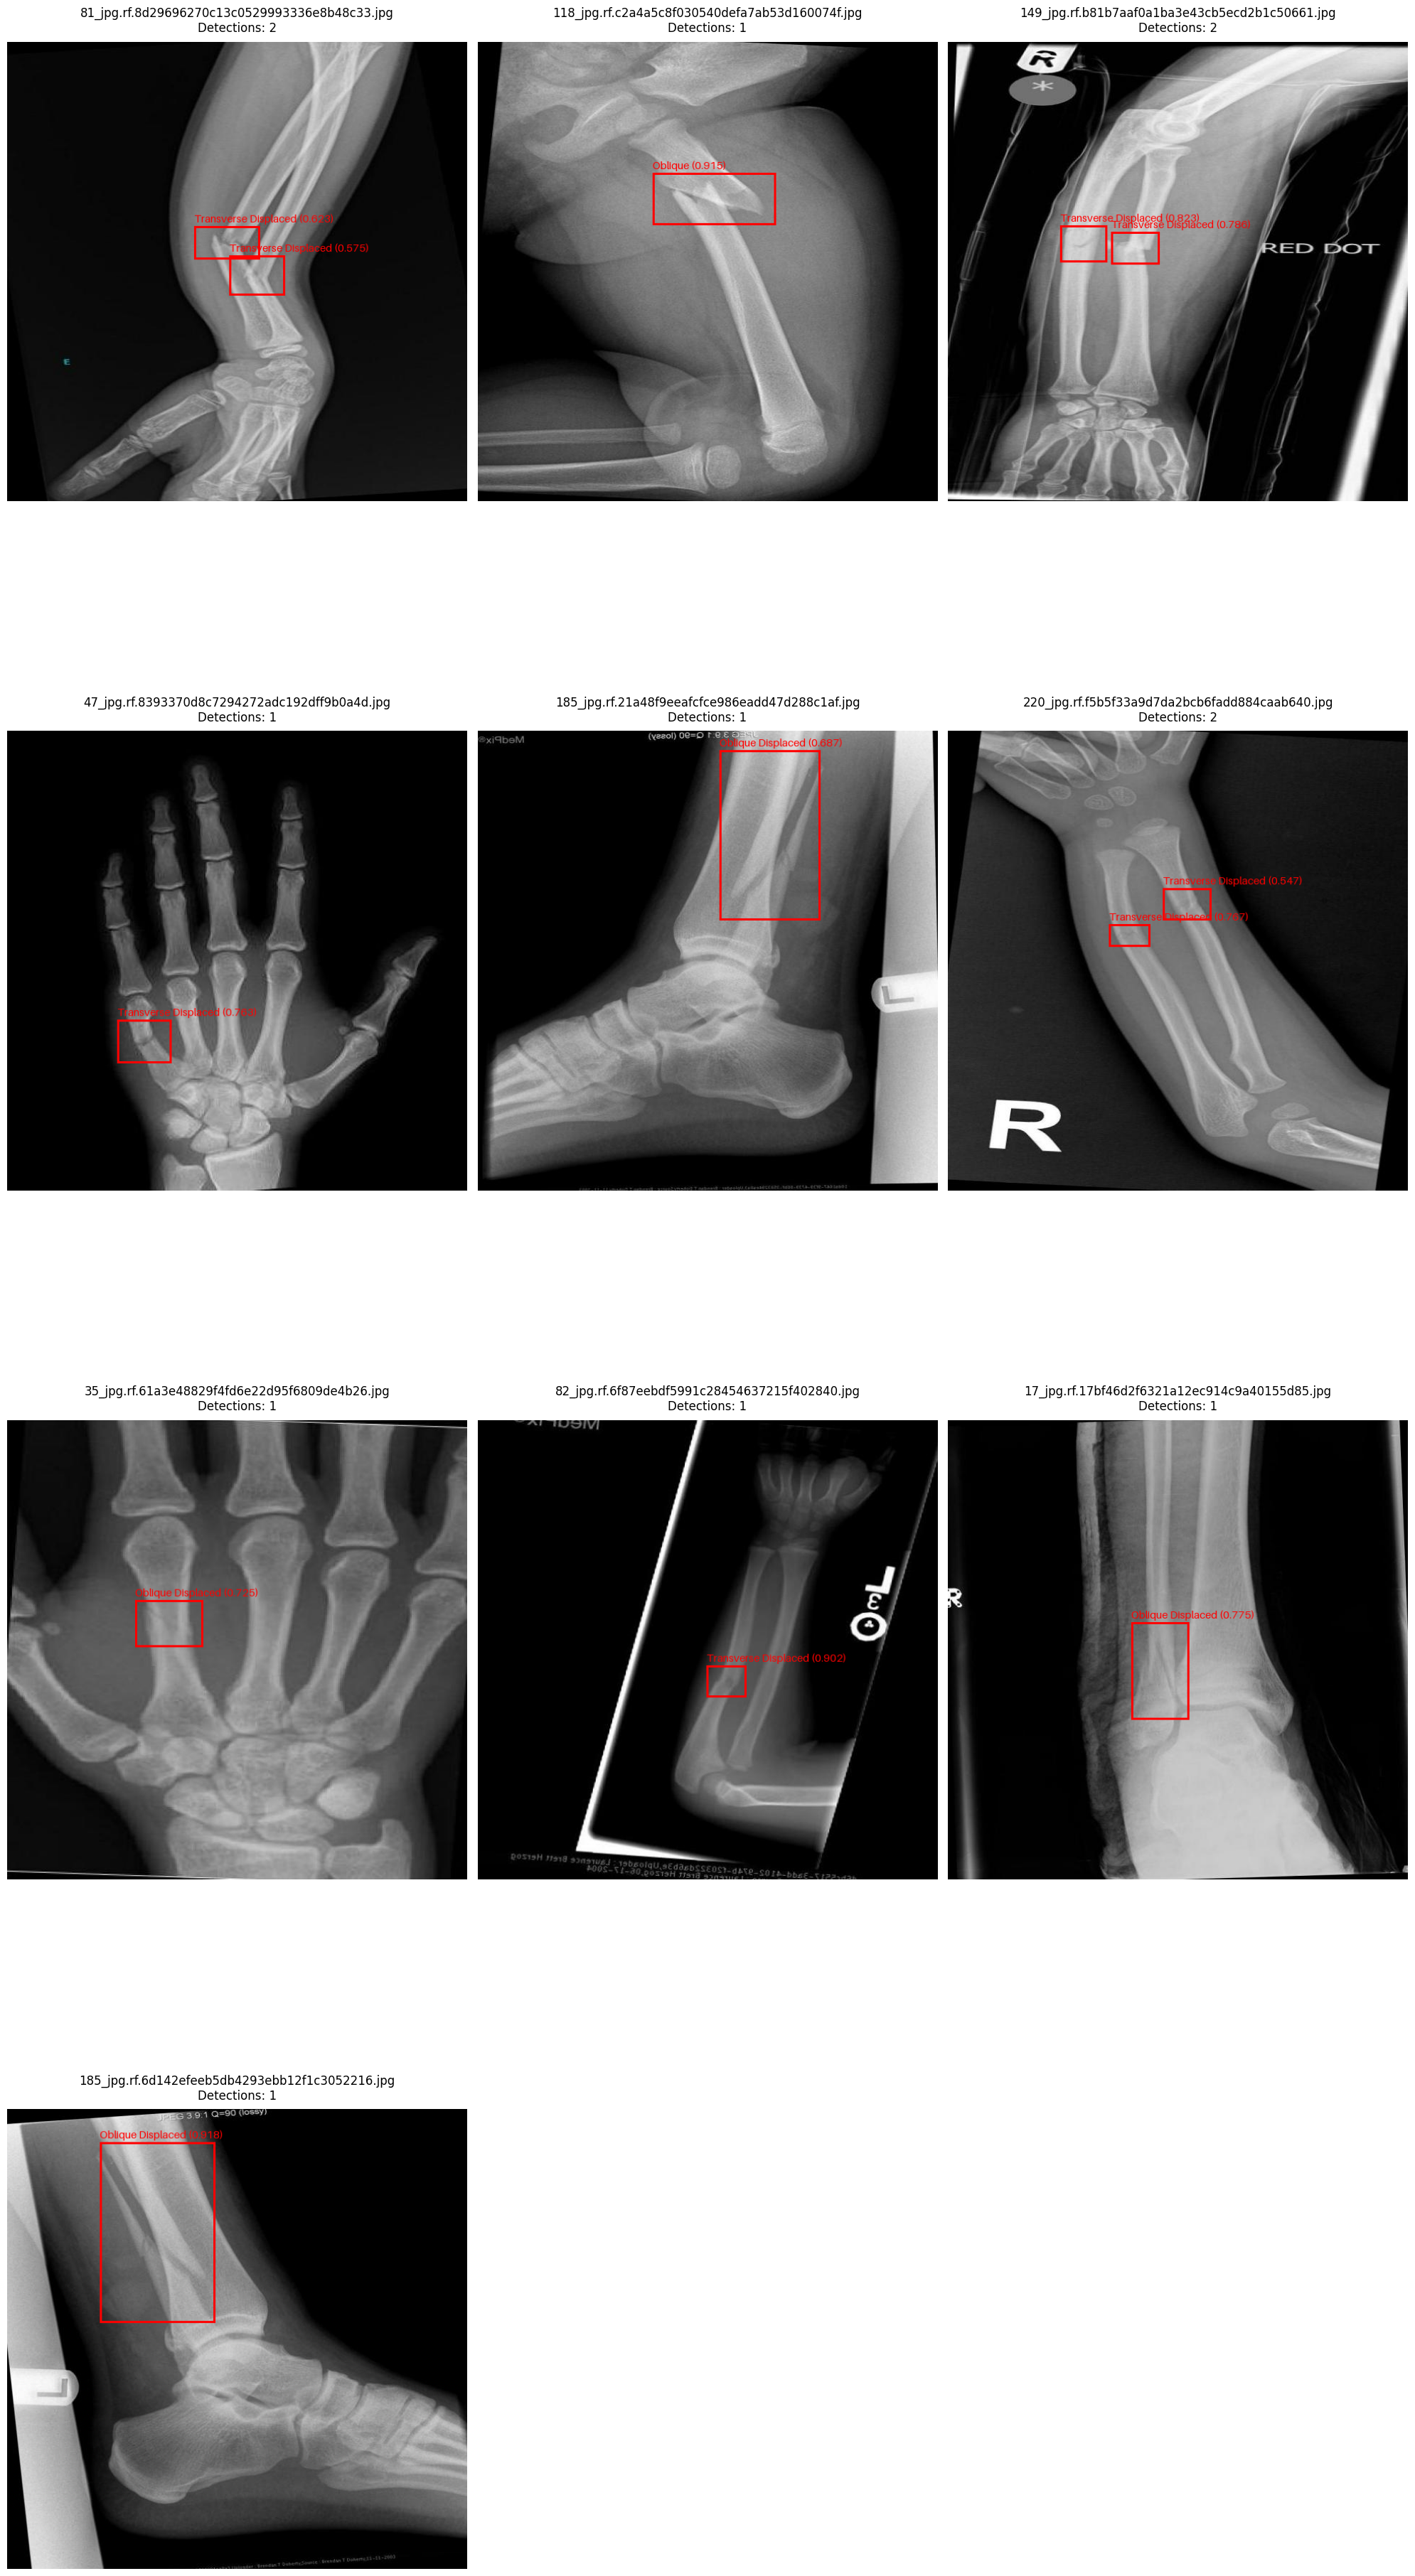

Predictions completed. Results saved to the 'runs/detect/predict' directory.


In [30]:
from ultralytics import YOLO
import os
import random
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np

# Đường dẫn đến mô hình đã huấn luyện (sử dụng best.pt sau huấn luyện)
model_path = os.path.join('result', 'bone_fracture_yolov8_optimized', 'weights', 'best.pt')

# Kiểm tra file mô hình
if not os.path.exists(model_path):
    print(f"Error: Model file {model_path} not found. Please check the path or ensure training is completed.")
    exit()
print(f"Found model at: {model_path}")

# Tải mô hình
model = YOLO(model_path)

# Đường dẫn đến thư mục validation
valid_dir = os.path.join('data', 'valid', 'images')

# Kiểm tra thư mục validation
if not os.path.exists(valid_dir):
    print(f"Error: Validation directory {valid_dir} not found. Please check the path.")
    exit()
print(f"Found validation directory at: {valid_dir}")

# Lấy danh sách các ảnh trong thư mục validation
image_files = [f for f in os.listdir(valid_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
if not image_files:
    print(f"No images found in {valid_dir}.")
    exit()
print(f"Found {len(image_files)} images in validation directory.")

# Chọn ngẫu nhiên 10 ảnh
num_samples = min(10, len(image_files))
sample_images = random.sample(image_files, num_samples)

# Tạo cửa sổ hiển thị tất cả ảnh với bố cục rõ ràng
plt.figure(figsize=(20, 10 * (num_samples // 3 + num_samples % 3)))  # 3 cột, số hàng tự động

# Dự đoán và hiển thị
for idx, image in enumerate(sample_images):
    image_path = os.path.join(valid_dir, image)
    print(f"\nPredicting on: {image_path}")
    results = model.predict(source=image_path, conf=0.5, save=True, save_txt=True)
    
    for result in results:
        boxes = result.boxes.xyxy.cpu().numpy()
        scores = result.boxes.conf.cpu().numpy()
        classes = result.boxes.cls.cpu().numpy()
        class_names = [model.names[int(cls)] for cls in classes]
        
        # print(f"Number of detections: {len(boxes)}")
        # for i in range(len(boxes)):
        #     print(f"Class: {class_names[i]}, Confidence: {scores[i]:.3f}, Box: {boxes[i]}")

        # Vẽ hộp giới hạn và hiển thị
        try:
            img = Image.open(image_path).convert("RGB")
            draw = ImageDraw.Draw(img)
            h, w = img.size
            
            if len(boxes) > 0:
                for j in range(len(boxes)):
                    x1, y1, x2, y2 = map(int, boxes[j])
                    # Đảm bảo tọa độ trong giới hạn ảnh
                    x1 = max(0, min(x1, w))
                    y1 = max(0, min(y1, h))
                    x2 = max(0, min(x2, w))
                    y2 = max(0, min(y2, h))
                    draw.rectangle([(x1, y1), (x2, y2)], outline="red", width=3)
                    text = f"{class_names[j]} ({scores[j]:.3f})"
                    draw.text((x1, y1 - 20), text, fill="red", font_size=15)  # Tăng kích thước chữ
            else:
                draw.text((10, 10), "No detections", fill="red", font_size=20)

            img_np = np.array(img)
            plt.subplot(num_samples // 3 + 1, 3, idx + 1)  # 3 cột, số hàng tự động
            plt.imshow(img_np)
            plt.title(f"{image}\nDetections: {len(boxes)}", fontsize=12, pad=10)
            plt.axis('off')
        except Exception as e:
            print(f"Error processing {image_path}: {e}")

plt.tight_layout()
plt.show()

print("Predictions completed. Results saved to the 'runs/detect/predict' directory.")

Sử dụng streamlit để chạy mô hình

In [ ]:
# streamlit run app.py